**In this notebook I am using embedding of product descriptions to find product similarity**

This method might give some redundant results becuase many items have the same descriptions. But it might be useful in a hybrid recommendation system or for comparison of different models.

* Embeddings are produced by 'universal-sentence-encoder' found on TensorFlow Hub
* Distance metric used is dot product
* Similarity score are stored in a pickle file due to memory constraints 'https://www.kaggle.com/datasets/mohammedobeidat/product-desc-similarity-scores'



In [17]:
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import pickle
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

path = '../input/h-and-m-personalized-fashion-recommendations/articles.csv'
 
df = pd.read_csv(path).astype(str)


the code loads a pre-trained Universal Sentence Encoder model using TensorFlow Hub, allowing you to use this model to convert sentences into numerical representations that capture their meanings. The specific version of the model to be loaded is determined by the URL provided in the module_url variable.

In [18]:
#@title Load the Universal Sentence Encoder's TF Hub module

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)

In [19]:
desc = df['detail_desc'].unique()

In [20]:
desc

array(['Jersey top with narrow shoulder straps.',
       'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
       'Semi shiny nylon stockings with a wide, reinforced trim at the top. Use with a suspender belt. 20 denier.',
       ...,
       'Short, A-line dress in jersey with a round neckline and V-shaped opening at the front with narrow ties. Long, voluminous raglan sleeves and wide cuffs with covered buttons.',
       'Large plastic hair claw.',
       'Calf-length dress in ribbed jersey made from a cotton blend. Low-cut V-neck at the back, dropped shoulders and long, wide sleeves that taper to the cuffs. Unlined.'],
      dtype=object)

In [21]:
embeds = model(desc)

In [22]:
with open('text_desc_embeddings.pickle', 'wb') as f:
    pickle.dump(embeds, f)
    
with open('text_desc.pickle', 'wb') as f:
    pickle.dump(desc, f)

In [23]:
file = open('scores_top20.pkl','wb')

for embed in embeds: 
    top10 = np.inner(embed, embeds)
    top10_index = np.argsort(-top10)[:20]
    top10_score = top10[top10_index]

    pickle.dump([top10_index, top10_score], file)

file.close()

In [24]:
def load_top10():
    
    top10_indecies = []
    top10_scores = []

    with open('../input/product-desc-similarity-scores/scores_top10.pkl', 'rb') as f:
        for i in range(len(desc)):
            try:
                row = pickle.load(f)
                top10_indecies.append(row[0])
                top10_scores.append(row[1])
            except:
                print('Done Loading')
                
    return top10_indecies, top10_scores

In [25]:
top10_indecies, top10_scores = load_top10()

In [26]:
def recommend(article_id):
    
    desc_list = desc.tolist()
    product_desc = df[df.article_id == sample]['detail_desc'].values[0]
    desc_index = desc_list.index(product_desc)
    rcmnds_indecies = top10_indecies[desc_index]
    rcmnds_scores = top10_scores[desc_index]
    rcmnds_descs = desc[rcmnds_indecies]
    map_dict = {i:j for i, j in zip(rcmnds_descs, rcmnds_scores)}
    rcmnds_article_ids = df[df.detail_desc.isin(rcmnds_descs)]
    rcmnds_article_ids['score'] = rcmnds_article_ids.detail_desc.map(map_dict)
    rcmnds_article_ids = rcmnds_article_ids[rcmnds_article_ids.score < 0.99]
    rcmnds_article_ids = rcmnds_article_ids.sort_values(by='score', ascending=False).drop_duplicates('score')
    
    
    return(rcmnds_article_ids[['article_id', 'score']])

In [27]:
def plot_items(items):
    path = "../input/h-and-m-personalized-fashion-recommendations/images"

    k = len(items)
    fig = plt.figure(figsize=(15, 10))
    for item, i in zip(items, range(1, k+1)):
        item = '0' + str(item)
        sub = item[:3]
        image = path + "/"+ sub + "/"+ item +".jpg"
        image = plt.imread(image)
        fig.add_subplot(1, k, i)
        plt.imshow(image)
        

In [57]:
sample = df.article_id.iloc[11]
rcmnds = recommend(sample)

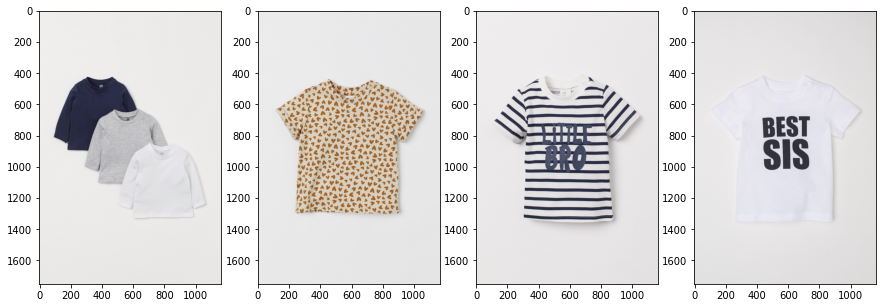

In [58]:
plot_items(rcmnds.sample(4).article_id.values)

In [59]:
trans = next(pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv', dtype=str, chunksize=10000))

trans.drop_duplicates(['customer_id', 'article_id'], inplace=True)
trans.article_id = trans.article_id.map(lambda x: x[1:])
grouped = trans.groupby('customer_id')

In [60]:
new = []
for group in grouped.groups:
    temp = grouped.get_group(group)
    if len(temp) >= 12:
        new.append([group, temp.article_id.values.tolist()[:12]])

In [61]:
def get_sim(item, items):
    
    item_desc = df.detail_desc[df.article_id == item].values[0]
    item_embed = model([item_desc])[0]
    
    items_desc = df[df.article_id.isin(items)].detail_desc
    items_embed = model(items_desc)
    scores = []
    
    for i in items_embed:
        sim = np.dot(i, item_embed)
        scores.append(sim)
        
        
    return np.mean(scores)

In [68]:
preds = []
scores = []

for key, value in new:
    temp = []
    for item in value[:6]:
        temp.append(recommend(item))
    temp2 = pd.concat(temp).sample(6, random_state=42)
    temp2['actual'] = value[6:]
    temp3 = []
    for item in temp2.actual:
        sim = get_sim(item, temp2.article_id) 
        temp3.append(sim)
        
    scores.append(np.mean(temp3))
    preds.append([key, temp2])

In [69]:
np.mean(scores)

0.41395026

In [70]:
customer = preds[0][1]

In [71]:
customer

,article_id,score,actual
62162,735523001,0.594901,685687002
98817,880973001,0.608802,680912006
32662,635895004,0.605709,692454002
71670,764758003,0.694582,640639001
77534,789998001,0.600119,664421002
88156,831752001,0.610480,680912009


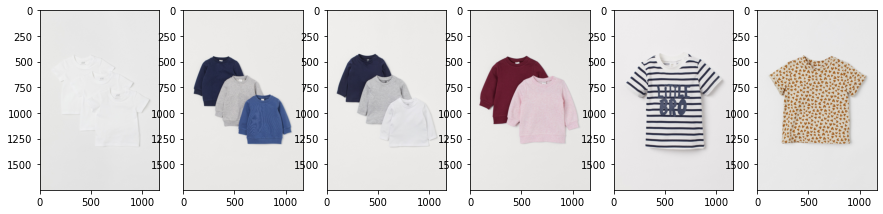

In [72]:
plot_items(customer.article_id.values)

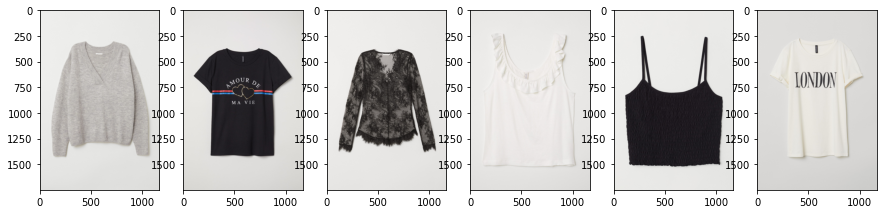

In [73]:
plot_items(customer.actual.values)